# Amazon UK product classificatio with NLP

## 1 - Import dataset

### 1.1 download and unpack dataset

In [1]:
! rm -rf data
! mkdir -p data/raw
! curl -o './data/raw/amazon_reviews_multilingual_UK_v1_00.tsv.gz' 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_UK_v1_00.tsv.gz'
! gunzip './data/raw/amazon_reviews_multilingual_UK_v1_00.tsv.gz'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M  100  333M    0     0   922k      0  0:06:09  0:06:09 --:--:-- 1076k0     0  1287k      0  0:04:24  0:00:13  0:04:11  665k 0  0:05:21  0:03:32  0:01:49  484k  0:06:17  0:05:14  0:01:03  455k    0   902k      0  0:06:18  0:05:15  0:01:03  479k 83  279M    0     0   898k      0  0:06:19  0:05:18  0:01:01  563k


## 2 - Data Analysis & Preparation

### 2.1 - Reading data

In [2]:
import pandas as pd

In [23]:
df = pd.read_csv('./data/raw/amazon_reviews_multilingual_UK_v1_00.tsv',  sep='\t', error_bad_lines=False)

b'Skipping line 101882: expected 15 fields, saw 22\nSkipping line 115512: expected 15 fields, saw 22\n'
b'Skipping line 328404: expected 15 fields, saw 22\n'
b'Skipping line 1412642: expected 15 fields, saw 22\n'


In [24]:
df.head(2)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,UK,10349,R2YVNBBMXD8KVJ,B00MWK7BWG,307651059,My Favourite Faded Fantasy,Music,5,0,0,N,Y,Five Stars,The best album ever!,2014-12-29
1,UK,10629,R2K4BOL8MN1TTY,B006CHML4I,835010224,Seiko 5 Men's Automatic Watch with Black Dial ...,Watches,4,0,0,N,Y,Great watch from casio.,What a great watch. Both watches and strap is ...,2013-10-24


### 2.2 - Removing unnecessary columns

In [25]:
df = df[['product_title', 'product_category', 'review_body', 'review_headline']]

### 2.3 - Droping nan rows

In [26]:
df = df.dropna()

### 2.4 - Check class proportions (product_category)

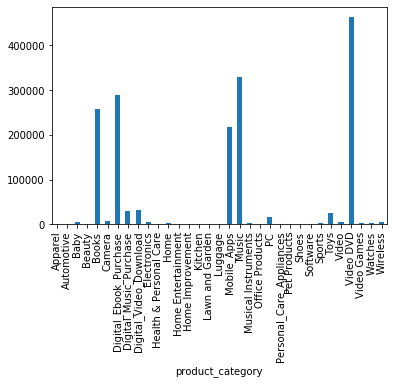

In [27]:
df[['product_category']].groupby(['product_category']).size().plot.bar()

In [8]:
df.head(2)

,product_title,product_category,review_body,review_headline
0,My Favourite Faded Fantasy,Music,The best album ever!,Five Stars
1,Seiko 5 Men's Automatic Watch with Black Dial ...,Watches,What a great watch. Both watches and strap is ...,Great watch from casio.


## 3 - Transform Dataset

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

### 3.1 - Generate Train and Test Dataset

In [10]:
def generate_train_test(df, target, train_size, random_state=42):
    """Generate train and test dataset. 

        :param pandas.DataFrame df: Dataset.
        :param string target: Name of target column.
        :param float train_size: Size of train proportion (0 <= train_size <= 1).
        :param int random_state: Seed for Random state. Default 42.
        :return: X_train, y_train, X_test, y_test.
        :rtype: tuple(pandas.DataFrame)
    """
    test_size = 1 - train_size
    columns = list(df.columns.values)
    columns.remove(target)
    
    train, teste = train_test_split(df, train_size=test_size, test_size=test_size, random_state=random_state)
    
    X_train = train[columns]
    y_train = train[[target]]
    
    X_test = teste[columns]
    y_test = teste[[target]]
    
    return (X_train, y_train, X_test, y_test)

In [11]:
target = 'product_category'
train_size = 0.7
X_train, y_train, X_test, y_test = generate_train_test(df, target, train_size)
del df

### 3.2 - Create Sklearn Selector for Pipeline

In [12]:
class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

        
    def fit(self, X, y=None):
        return self

    
    def transform(self, X):
        return X[self.key]

### 3.3 - Create invividual pipeline for each column

In [13]:
def create_tf_idf_pipeline(column):
    """Generate Tf-idf sklean pipeline in a column.

        :param string column: column to perform the transformation.
        :return: pipeline.
        :rtype: sklearn.pipeline.Pipeline
    """
    pipeline = Pipeline([
        (column, Selector(key=column)),
        ('tfidf', TfidfVectorizer(stop_words='english'))
    ])
    return pipeline

In [14]:
product_title_pipeline = create_tf_idf_pipeline('product_title')
review_body_pipeline = create_tf_idf_pipeline('review_body')
review_headline_pipeline = create_tf_idf_pipeline('product_title')

### 3.4 - Union of pipelines in a single one

In [15]:
from sklearn.pipeline import FeatureUnion

In [16]:
feats = FeatureUnion([
    ('product_title', product_title_pipeline), 
    ('review_body', review_body_pipeline),
    ('review_headline', review_headline_pipeline)
])

## 4 - ML Model (Naive Bayes) 

### 4.1 - Fit Naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB

nb_pipeline = Pipeline([
    ('features', feats),
    ('classifier', MultinomialNB(fit_prior=False)),
])

nb_pipeline.fit(X_train, y_train)

/Users/bernardocosta/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('product_title',
                                                 Pipeline(memory=None,
                                                          steps=[('product_title',
                                                                  Selector(key='product_title')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',


### 4.3 - Predict

In [18]:
predicted = nb_pipeline.predict(X_test)

### 4.4 - Get Accuracy

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
def get_accuracy(y_test, predicted):
    accuracy = accuracy_score(y_test, predicted)
    accuracy = accuracy * 100.0
    return accuracy

In [21]:
accuracy = get_accuracy(y_test, predicted)
print(accuracy, '%')

87.34076542027768 %


# Refs
- https://www.kaggle.com/baghern/a-deep-dive-into-sklearn-pipelines
- https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
- https://towardsdatascience.com/machine-learning-nlp-text-classification-using-scikit-learn-python-and-nltk-c52b92a7c73a